In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.constants as const
plt.rcParams['figure.dpi'] = 150
%matplotlib inline
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=14)
plt.rc("legend", fontsize=14, loc="upper left")

cm = 1.5/2.54 #define ratio for cm and inches

In [12]:
Data_names = []

# Method for going through all the data we have, and it fucking works dawg
for (dir_path, dir_names, file_names) in os.walk('./Data_Labday_1'):
    for file_name in file_names:
        if file_name.endswith('.txt'): #ensures we grab only the files ending with .txt
            Data_names.append(os.path.join(dir_path, file_name))

In [27]:
time = [] #array for all time data lists
V1 = [] #Same again for votlage readings

for Data_name in Data_names:
    Data = np.loadtxt(Data_name, skiprows=3)
    time.append(Data[:, 0])
    V1.append(Data[:, 1])  # Assuming V1 is in the first column
    #print(time)
    #print(V1)

20

In [29]:
#Here we make the functions for the fits used
#Guesses for the linear function
a_lin_guess = 1.2 
k_lin_guess = 21e-8 
offset_lin_guess = 0.4
p0_lin = [a_lin_guess, k_lin_guess, offset_lin_guess]

frequency = (2*np.pi)/(633e-9)

#Linear fit function hoping that it works on a linear fit
def Linear_fit(t, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    return amplitude *(np.cos(frequency*2*k*t)) + offset

#Guesses for the quadratic fit
a_quad_guess = 2
k_quad_guess = 21e-9
offset_quad_guess = 0.4
n_quad_guess = 0
p0_Quad = [a_quad_guess, k_quad_guess, offset_quad_guess, n_quad_guess]

#Quadratic fit function if it works like this
def Quad_fit(t, *p): 
    amplitude = p[0]
    k = p[1]
    offset = p[2]
    n = p[3]
    return amplitude *(np.cos(frequency*2*(k*t**2+n*t))) + offset

Linear Parameters:
Amplitude: -0.641884253026113 $\pm$ 0.005109883858089573
k: 2.1608767572289639e-07 $\pm$ 9.39738279697371e-11
Offset: 14.135012615964092 $\pm$ 0.003637518279829863

Fitted Parameters:
Amplitude: 0.9044733314517348 +/- [0]
k: 9.60052696109252e-09 +/- 4.5473163548871394e-11
Offset: 14.111212987069067 +/- 0.003651386803486105
n: 7.471733295706402e-08 +/- 2.646078326963326e-10


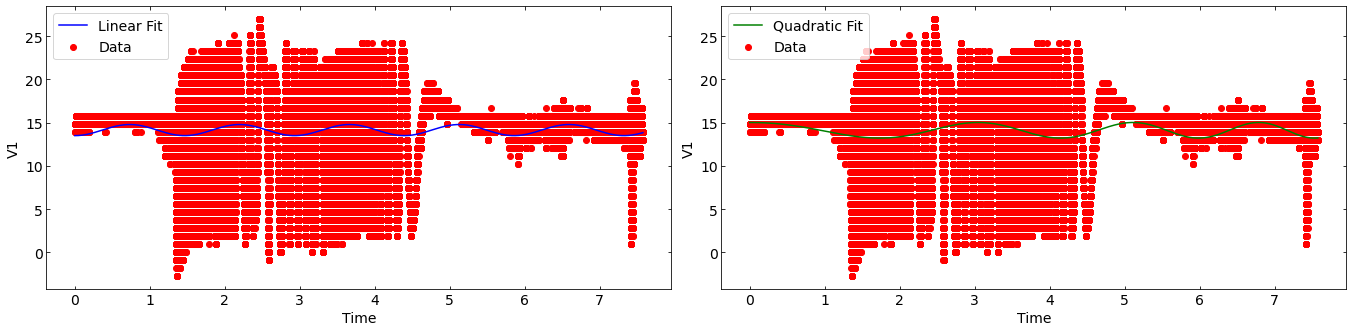

Linear Parameters:
Amplitude: -0.5986523766191829 $\pm$ 0.005187202371008056
k: 2.1667401298838926e-07 $\pm$ 1.0472026899646177e-10
Offset: 14.40518653934301 $\pm$ 0.0036932646668015115

Fitted Parameters:
Amplitude: 0.7185109556269489 +/- [0]
k: 1.4789919855336262e-08 +/- 5.79430049024706e-11
Offset: 14.341986484105393 +/- 0.0037205118870363017
n: 3.356419312863925e-08 +/- 3.345373609755665e-10


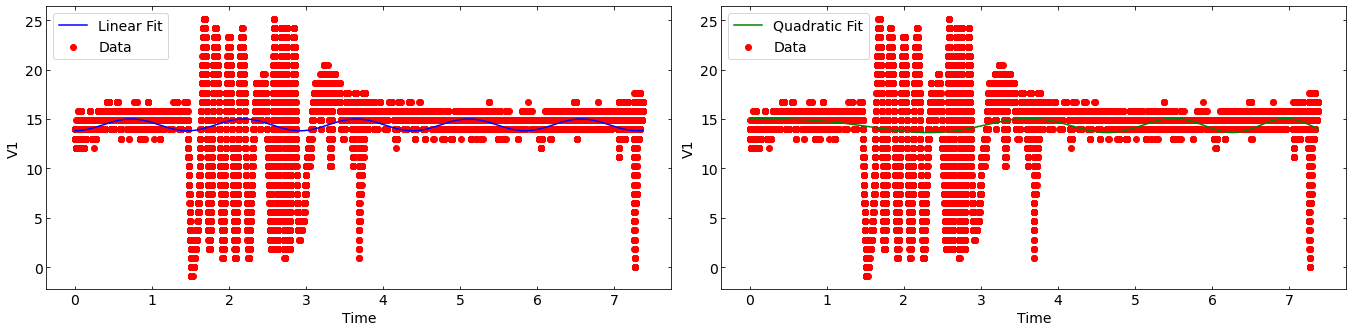

Linear Parameters:
Amplitude: -0.7884345313565458 $\pm$ 0.0052951037916998366
k: 2.0996333964741568e-07 $\pm$ 8.487817614299345e-11
Offset: 13.982825682628365 $\pm$ 0.0037675061703600432

Fitted Parameters:
Amplitude: 0.5123473808460194 +/- [0]
k: 2.1653748170524636e-08 +/- 9.299517093658566e-11
Offset: 13.916205275506302 +/- 0.003934150527458567
n: -5.743634245942188e-09 +/- 5.125565315055509e-10


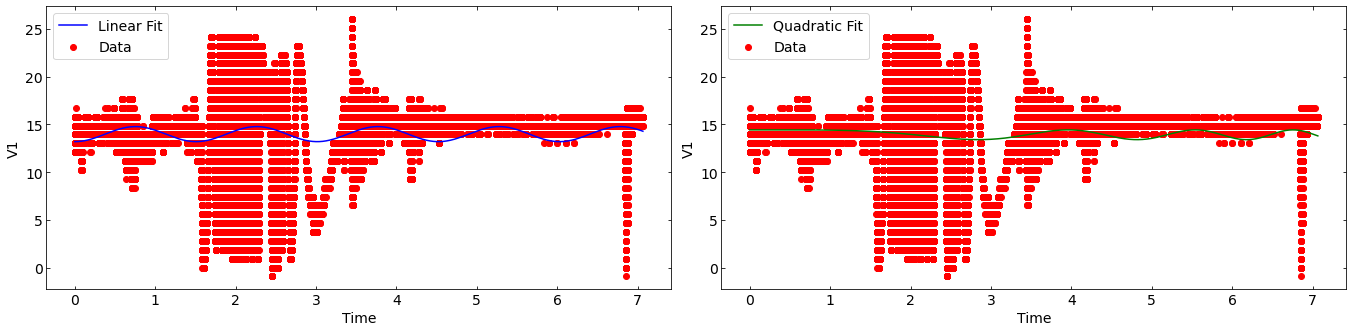

Linear Parameters:
Amplitude: 0.30189919325351694 $\pm$ 0.004849449423539488
k: 2.1265847821828037e-07 $\pm$ 1.7170859138673365e-10
Offset: 11.98509436230032 $\pm$ 0.003455841653234875

Fitted Parameters:
Amplitude: -1.7232253801446031 +/- [0]
k: 1.630050622004487e-08 +/- 1.9691688375388476e-11
Offset: 12.647324438748452 +/- 0.004091315665093726
n: -2.0561068663678653e-07 +/- 1.2380907464396792e-10


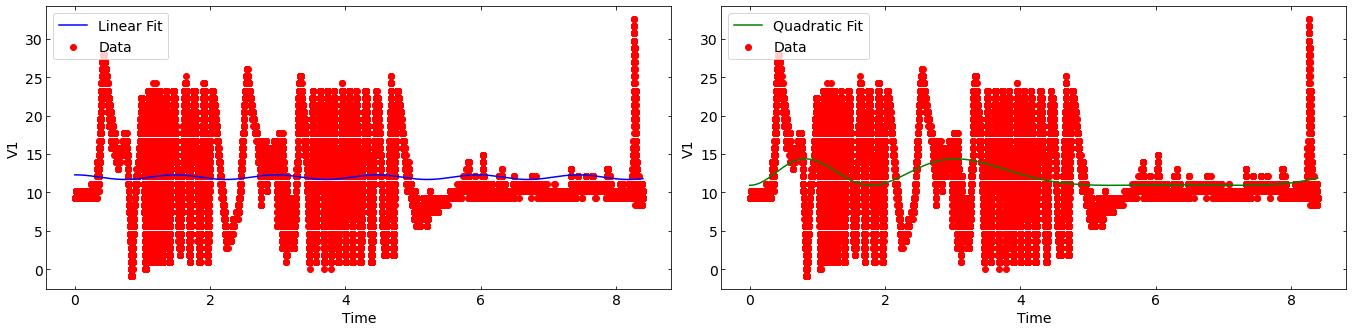

Linear Parameters:
Amplitude: -0.2963666957016556 $\pm$ 0.0046691408367550225
k: 1.9795546083577477e-07 $\pm$ 1.4820495615886232e-10
Offset: 13.713753770858018 $\pm$ 0.0032966210059182832

Fitted Parameters:
Amplitude: 0.757474925404742 +/- [0]
k: 2.0036679595066585e-08 +/- 3.2090155929064954e-11
Offset: 13.677536956593745 +/- 0.003309706518217921
n: 3.2203069339099284e-08 +/- 2.3020940590489732e-10


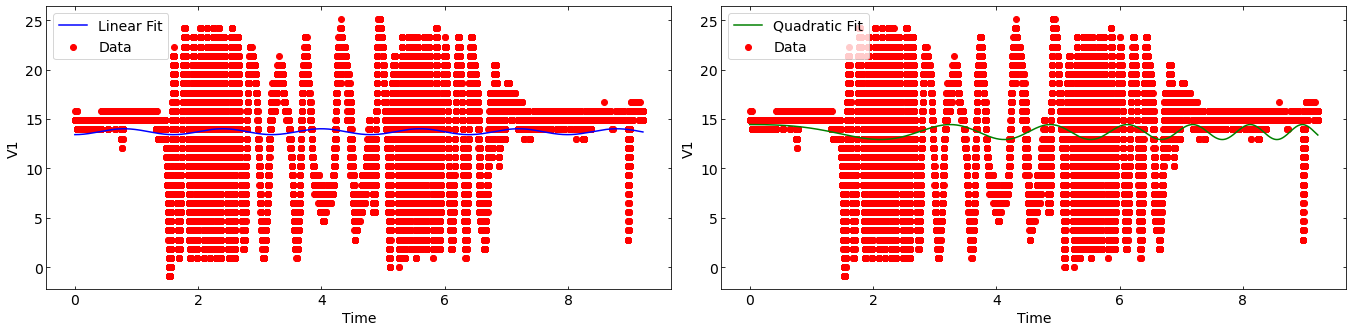

Linear Parameters:
Amplitude: 0.30787425997044393 $\pm$ 0.004581255784962106
k: 2.1141294445944385e-07 $\pm$ 1.3256460753025088e-10
Offset: 13.645867872450408 $\pm$ 0.0032284247789959694

Fitted Parameters:
Amplitude: 1.4536173437000768 +/- [0]
k: 2.2648262111222374e-08 +/- 1.5373235929850368e-11
Offset: 13.530374065878778 +/- 0.0032566386428693273
n: 1.9423350879593508e-09 +/- 1.1416497219711404e-10


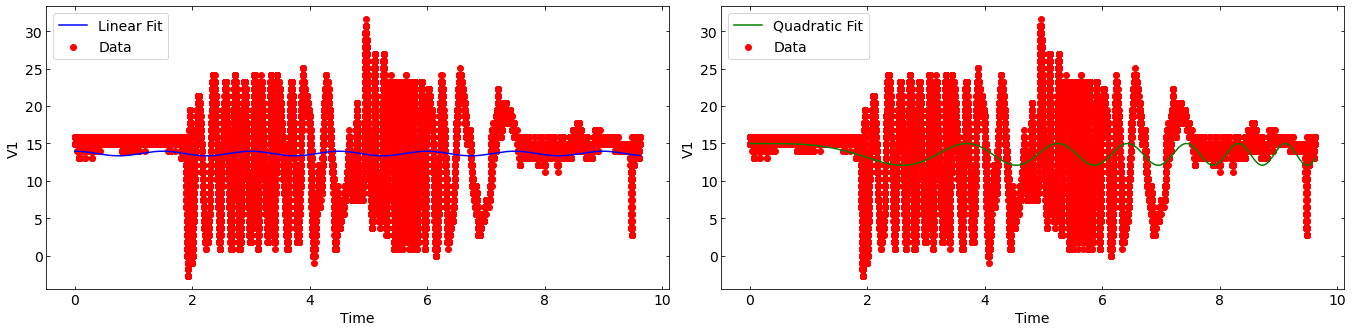

Linear Parameters:
Amplitude: -0.7039451053766984 $\pm$ 0.004447817629958634
k: 2.0879776482318694e-07 $\pm$ 5.646839785440711e-11
Offset: 13.497336439824492 $\pm$ 0.0031665063244741927

Fitted Parameters:
Amplitude: 1.931005984106404 +/- [0]
k: 1.8491695533382397e-08 +/- 1.0487712995619055e-11
Offset: 13.405124623342111 +/- 0.0031762749345731994
n: 2.225510084105197e-08 +/- 8.092434349566672e-11


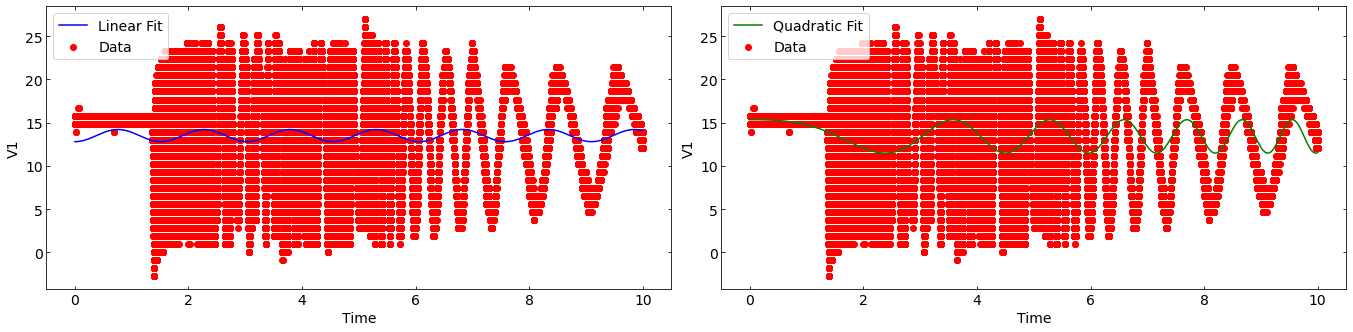

Linear Parameters:
Amplitude: -1.3023065588021074 $\pm$ 0.004577858257715954
k: 1.8821116212240579e-07 $\pm$ 3.351530258573925e-11
Offset: 13.532647668482722 $\pm$ 0.0032640130263849845

Fitted Parameters:
Amplitude: -1.132894617605502 +/- [0]
k: 2.3094290473144695e-08 +/- 2.0737825062560447e-11
Offset: 13.65807140567694 +/- 0.00329440301055258
n: 2.0035123842531866e-09 +/- 1.5091366350160892e-10


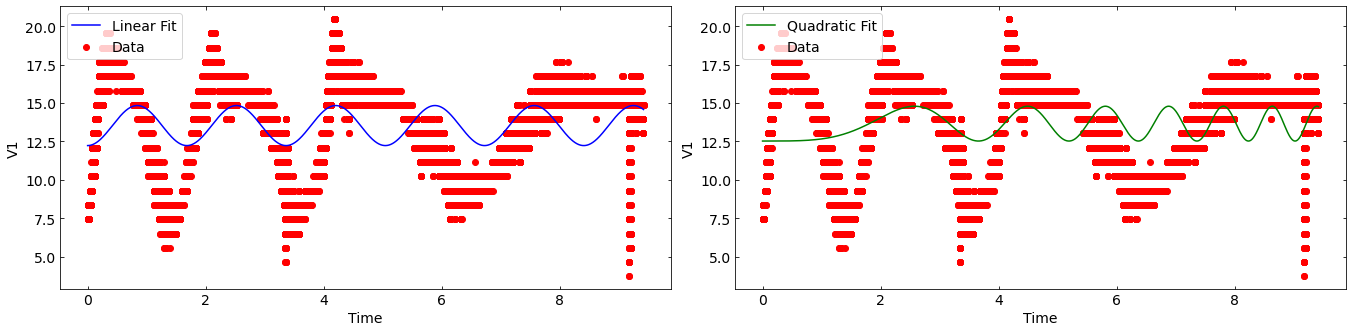

Linear Parameters:
Amplitude: -0.8602218439522712 $\pm$ 0.004494131574792595
k: 1.9965084770900262e-07 $\pm$ 4.479172681814873e-11
Offset: 13.763484855518028 $\pm$ 0.003164812402245667

Fitted Parameters:
Amplitude: 0.8107316825052119 +/- [0]
k: 1.1545974466696117e-08 +/- 2.4427071264560363e-11
Offset: 13.67134327398139 +/- 0.003240579289977286
n: 5.971031093305142e-09 +/- 1.907141229202554e-10


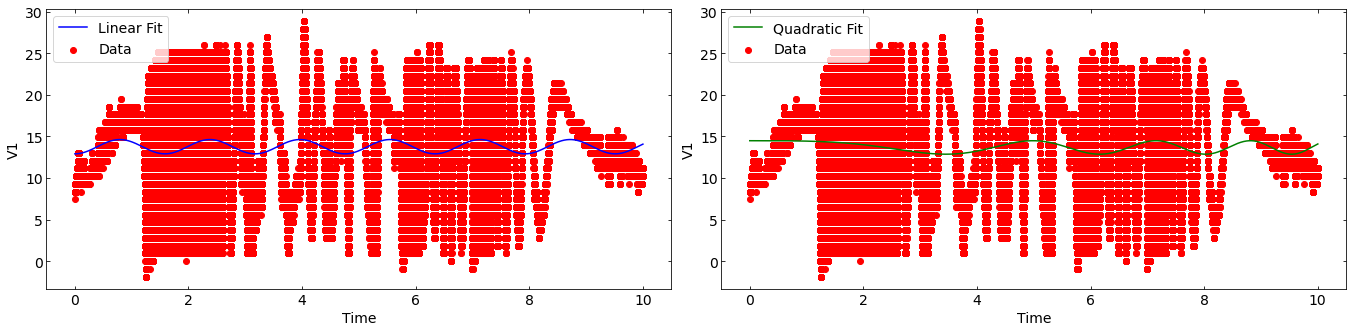

Linear Parameters:
Amplitude: -0.5774608792844315 $\pm$ 0.011481932489584623
k: 2.592703137839776e-07 $\pm$ 9.564420021273432e-10
Offset: 14.68233079768533 $\pm$ 0.008012596132324338

Fitted Parameters:
Amplitude: -0.5883146590224985 +/- [0]
k: -3.469418217255162e-07 +/- 7.652107381488873e-09
Offset: 14.456415536806803 +/- 0.014361741004054516
n: 4.6281442596114455e-07 +/- 1.0155021408282617e-08


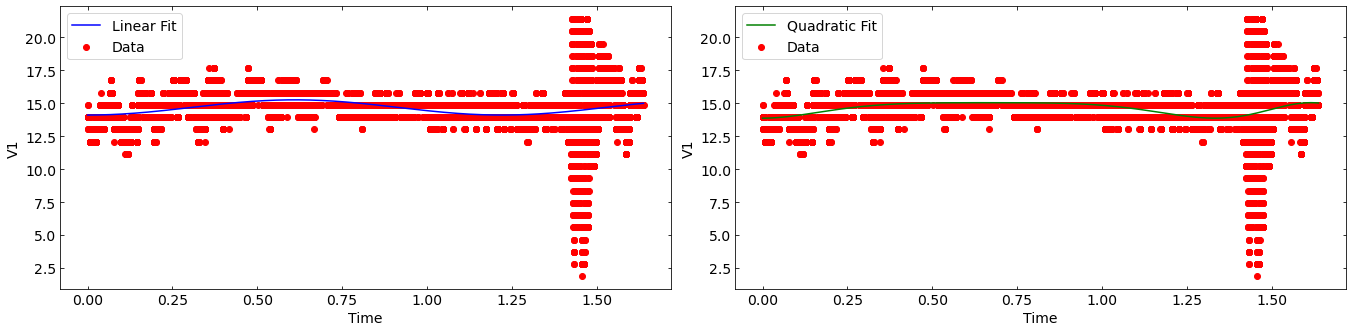

Linear Parameters:
Amplitude: 1.2239640052981429 $\pm$ 0.008318319727547138
k: 2.436562518480772e-07 $\pm$ 1.925074437079119e-10
Offset: 13.453867381688202 $\pm$ 0.005835909234140293

Fitted Parameters:
Amplitude: -3.9173378829544863 +/- [0]
k: -1.4146407069074995e-08 +/- 1.4900499262836172e-10
Offset: 12.055419952140433 +/- 0.009703537824080026
n: 1.1395051730320138e-07 +/- 3.4667349200306473e-10


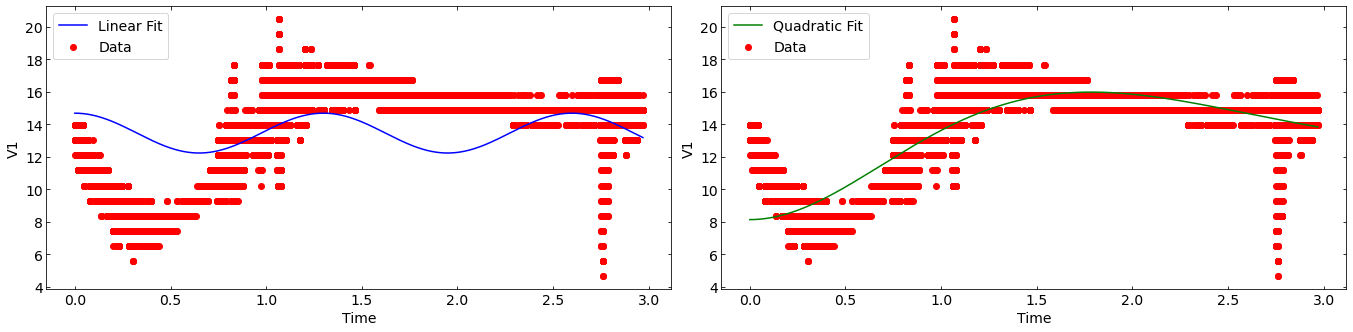

Linear Parameters:
Amplitude: -0.5952035345273953 $\pm$ 0.0044541424592626985
k: 2.0765155409493043e-07 $\pm$ 6.652559188689668e-11
Offset: 12.480619477561428 $\pm$ 0.003167283159839284

Fitted Parameters:
Amplitude: -1.1270709646255204 +/- [0]
k: 2.7251664104163807e-08 +/- 1.7703605249462788e-11
Offset: 12.517494058271401 +/- 0.0031688112964834056
n: 3.831760539883122e-08 +/- 1.3757009928993028e-10


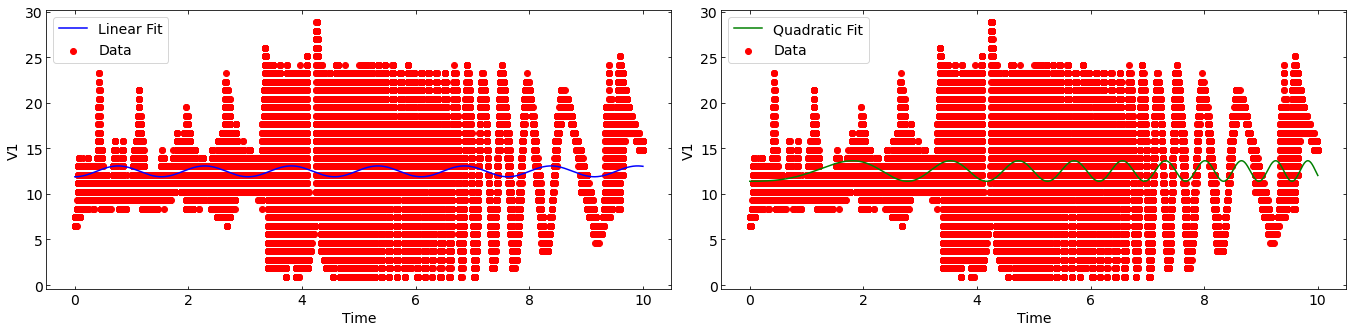

Linear Parameters:
Amplitude: -1.7925131360171922 $\pm$ 0.005156255768115721
k: 1.9920223817038836e-07 $\pm$ 3.414423908528003e-11
Offset: 13.820206299356489 $\pm$ 0.0036622492910648365

Fitted Parameters:
Amplitude: 1.706558645378643 +/- [0]
k: 2.2671585324083163e-08 +/- 2.5186083318694437e-11
Offset: 13.62394565430176 +/- 0.0037865240179834683
n: -1.3121230424549268e-08 +/- 1.4514911735582116e-10


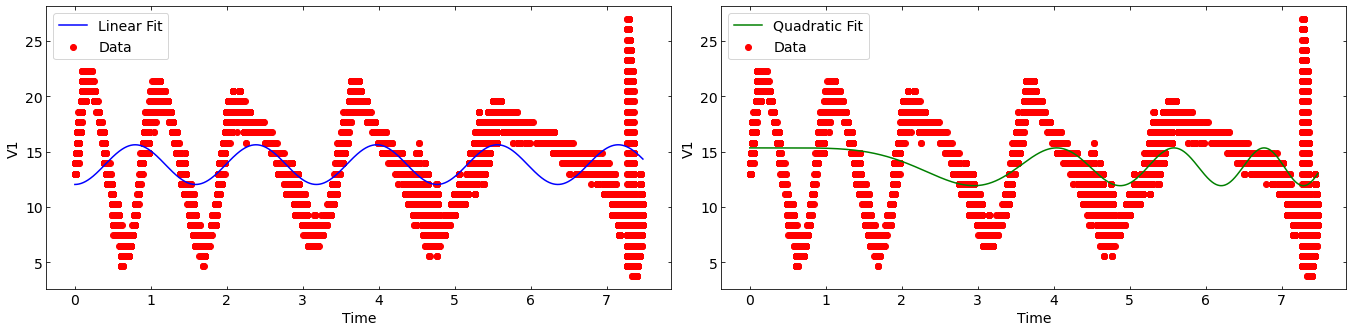

Linear Parameters:
Amplitude: -0.41502368969215125 $\pm$ 0.004481167929377177
k: 2.04987376748654e-07 $\pm$ 9.372533657738341e-11
Offset: 14.041450485580489 $\pm$ 0.0031678825499132385

Fitted Parameters:
Amplitude: 0.806563269306044 +/- [0]
k: 2.331600518914582e-08 +/- 2.5441034216723858e-11
Offset: 13.94439573829057 +/- 0.0032298319798663377
n: -9.253727852326333e-09 +/- 1.9601264641713924e-10


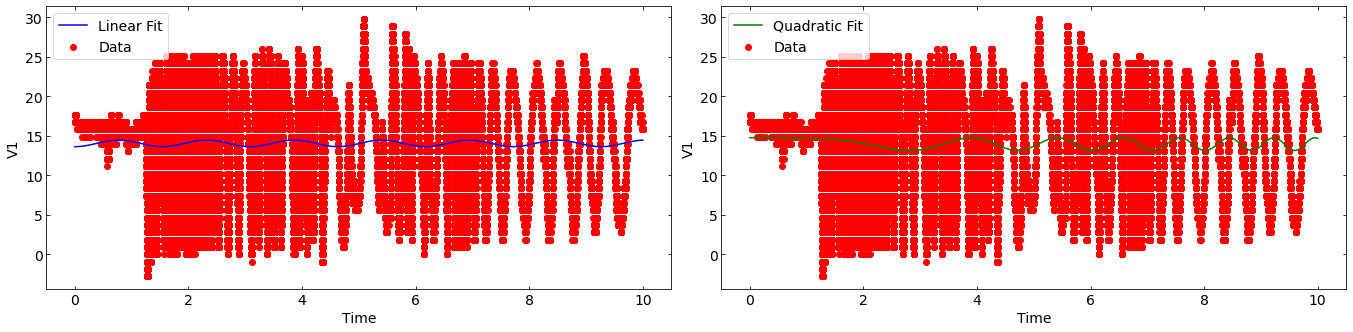

Linear Parameters:
Amplitude: -1.8468503468565638 $\pm$ 0.004644942787500493
k: 2.2469794814177652e-07 $\pm$ 2.41588287944895e-11
Offset: 13.219293404295449 $\pm$ 0.0032996295297406846

Fitted Parameters:
Amplitude: 1.0794849507398285 +/- [0]
k: 2.1844912752190314e-08 +/- 2.3315049702290252e-11
Offset: 13.131956510372838 +/- 0.0033455875607222517
n: 9.130173176905065e-09 +/- 1.651455302818139e-10


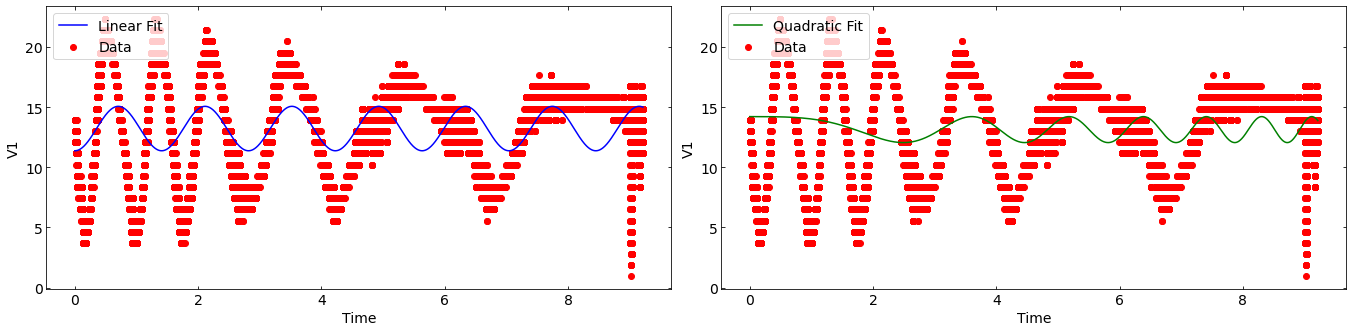

Linear Parameters:
Amplitude: 0.1958161895312699 $\pm$ 0.004466950210670789
k: 2.0628186565210243e-07 $\pm$ 2.0055069469981674e-10
Offset: 13.192430963114502 $\pm$ 0.003167845945178103

Fitted Parameters:
Amplitude: 1.0082811696670955 +/- [0]
k: 1.6353431100024525e-08 +/- 2.0276202925895628e-11
Offset: 13.173282145525747 +/- 0.0031652809863769865
n: 4.62721624853229e-08 +/- 1.559742192445996e-10


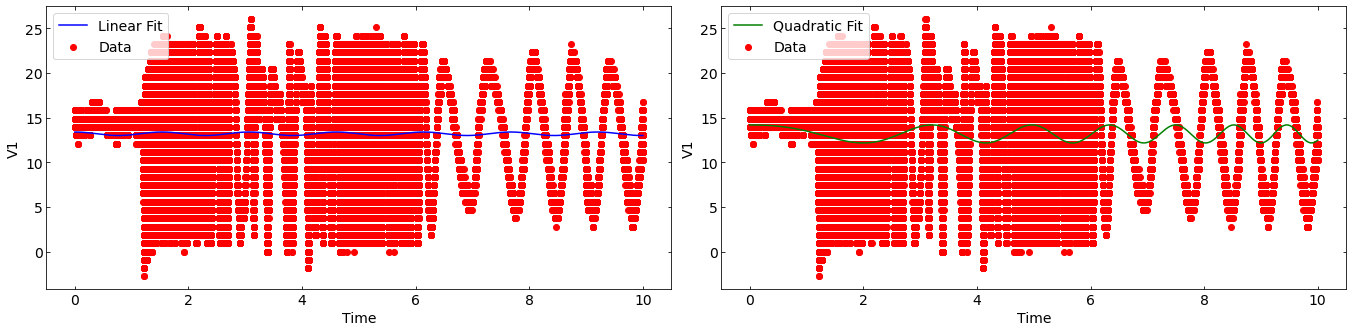

Linear Parameters:
Amplitude: 0.8242633953700127 $\pm$ 0.004495659112094856
k: 2.0332979703440305e-07 $\pm$ 4.672230312196407e-11
Offset: 14.318615332599908 $\pm$ 0.0031672642509776965

Fitted Parameters:
Amplitude: 1.7557732350706874 +/- [0]
k: 2.4312317573449085e-08 +/- 1.1500693884036286e-11
Offset: 14.072119601153709 +/- 0.003249820992161469
n: -2.542762970185893e-08 +/- 8.958849228132642e-11


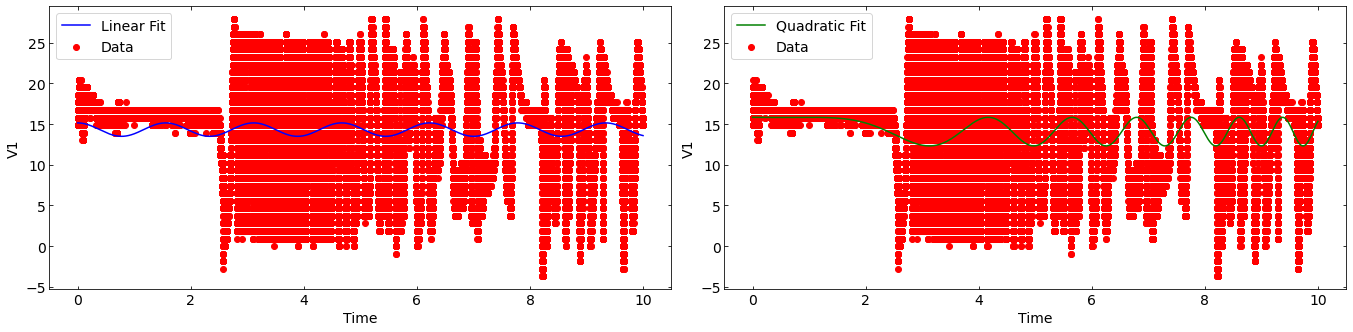

Linear Parameters:
Amplitude: -0.6703440327948997 $\pm$ 0.004750093415191084
k: 2.048255932980098e-07 $\pm$ 7.132813086648346e-11
Offset: 13.61948254897444 $\pm$ 0.0033728488697655178

Fitted Parameters:
Amplitude: 1.228033985846127 +/- [0]
k: 1.5175074577964702e-08 +/- 2.274823372449555e-11
Offset: 13.604443909204353 +/- 0.0033801110159750376
n: 3.510768138564859e-08 +/- 1.5428100468398856e-10


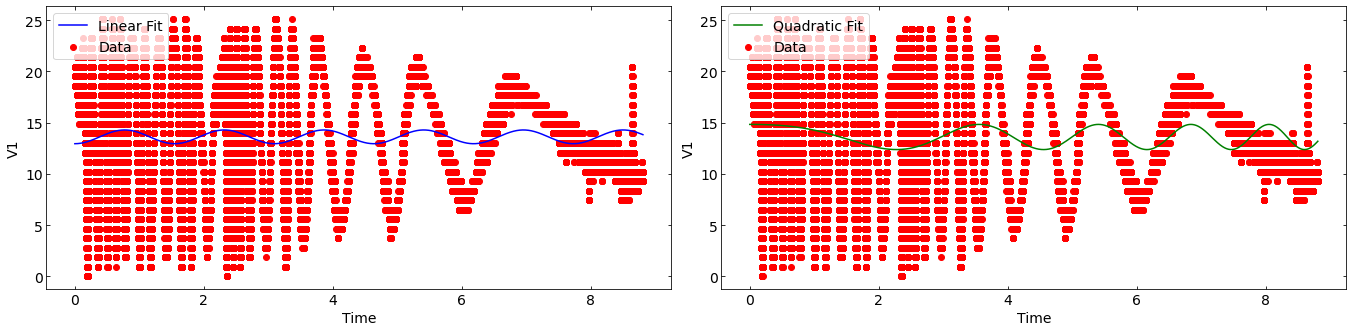

Linear Parameters:
Amplitude: 0.3540148265693345 $\pm$ 0.004457627388323912
k: 2.7106922701587785e-07 $\pm$ 1.1145711674199926e-10
Offset: 14.043487679242583 $\pm$ 0.0031651571243209785

Fitted Parameters:
Amplitude: -0.5289920323856546 +/- [0]
k: 2.7202909722448307e-08 +/- 3.927041318540798e-11
Offset: 14.144962576582058 +/- 0.00328791186391746
n: -4.367803292744065e-08 +/- 3.0418346486839407e-10


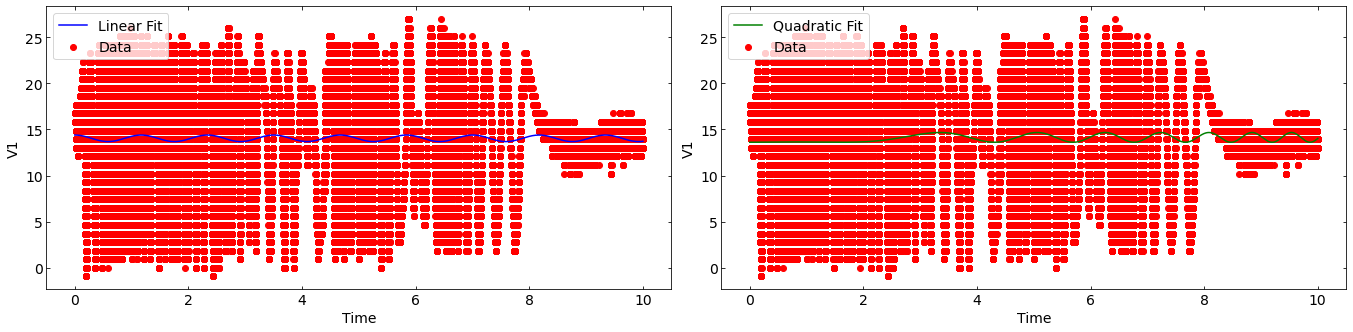

Linear Parameters:
Amplitude: 1.010780574305162 $\pm$ 0.013116345516952545
k: 2.9516412980228033e-07 $\pm$ 1.2024108877755376e-09
Offset: 11.469292982763973 $\pm$ 0.010128610085671612

Fitted Parameters:
Amplitude: 1.7628979810256609 +/- [0]
k: 9.274320165181998e-07 +/- 2.8833355699099047e-09
Offset: 12.150982147927813 +/- 0.010993990063145716
n: -8.919829495897131e-07 +/- 2.53622288094797e-09


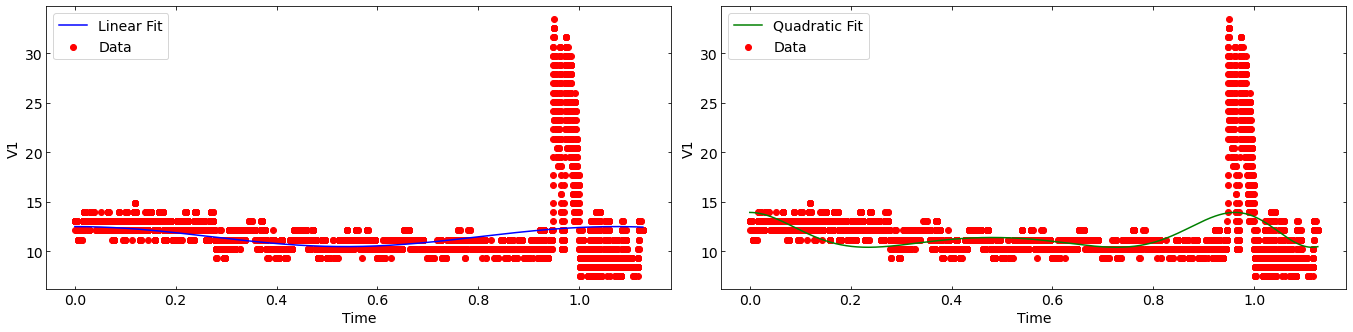

In [33]:
#Here using subplots to get 6 graphs for each iteration together.

lin_const = []
lin_sigma = []
quad_const =[]
quad_sigma =[]

fig, axes = plt.subplots(1,2, figsize=(32*cm,8*cm)) #figure done in inches, use this to choose a good scale
axes = axes.flatten() #Means we can iterate over it

#Here is my loop where i plot for curve fits with different powers.
for i in range(len(time)):
    # Linear fit
    axes[0].cla()  # Clear the first subplot
    plt.sca(axes[0])  # Set current axis to the first subplot
    popt_1, pcov_1 = sp.curve_fit(Linear_fit, time[i], V1[i], p0=p0_lin, absolute_sigma=True)
    # Calculate the standard deviations of the fitted parameters
    lin_err = np.sqrt(np.diag(pcov_1))
    plt.plot(time[i], Linear_fit(time[i], *popt_1), label='Linear Fit', color='blue')  # Plot linear fit
    plt.scatter(time[i], V1[i], label='Data', color='red')  # Plot data points
    plt.xlabel('Time')
    plt.ylabel('V1')
    plt.legend()

    # Quadratic fit
    axes[1].cla()  # Clear the first subplot
    plt.sca(axes[1])  # Set current axis to the second subplot
    popt_2, pcov_2 = sp.curve_fit(Quad_fit, time[i], V1[i], p0=p0_Quad, absolute_sigma=True)
    #calc standard deviation of the fitted parameters
    quad_err = np.sqrt(np.diag(pcov_2))
    plt.plot(time[i], Quad_fit(time[i], *popt_2), label='Quadratic Fit', color='green')  # Plot quadratic fit
    plt.scatter(time[i], V1[i], label='Data', color='red')  # Plot data points
    plt.xlabel('Time')
    plt.ylabel('V1')
    plt.legend()
    plt.tight_layout()
    
    #Print statements to get the fitted parameters
    print("Linear Parameters:")
    print("Amplitude:", popt_1[0], '$\pm$', lin_err[0])
    print("k:", popt_1[1], '$\pm$', lin_err[1])
    lin_const.append(popt_1[1])
    lin_sigma.append(lin_err[1])
    print("Offset:", popt_1[2], '$\pm$', lin_err[2])
    print()
    print("Fitted Parameters:")
    print("Amplitude:", popt_2[0], "+/-", [0])
    print("k:", popt_2[1], "+/-", quad_err[1])
    print("Offset:", popt_2[2], "+/-", quad_err[2])
    print("n:", popt_2[3], "+/-", quad_err[3])
    plt.show()